In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance

import matplotlib.pyplot as plt

import urllib.request
import json

## Récupération du tableau de features 

In [2]:
db_name = "../database/e-commerce.db"

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    # YOUR CODE
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        return conn
    except Error as e:
        print(e)
        


conn = create_connection(db_name)
conn

2.6.0


In [3]:
    cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
    cur.execute('''
                SELECT 
                order_item.item_id, 
                order_item.freight_value, 
                order_item.price, 
                weight_g,
                lenght_cm, 
                height_cm, 
                width_cm, 
                customer.zip_code, 
                seller.zip_code, 
                order_dataset.purchase_timestamp,
                order_dataset.order_estimated_delivery_date, 
                order_dataset.order_delivered_customer_date
                FROM product
                LEFT JOIN order_item ON product.id = order_item.product_id
                LEFT JOIN order_dataset ON order_item.order_id = order_dataset.order_id
                LEFT JOIN customer ON customer.id = order_dataset.customer_id          
                LEFT JOIN seller ON order_item.seller_id = seller.id                
                ''')
    
    res_cur = cur.fetchall()

In [4]:
df_bdd = pd.DataFrame(res_cur, columns=["nb_product", "prix_de_livraison", "product_price", "weight", "lenght", "height", "width", "zip_code_customer", "zip_code_seller", "date_purchase", "date_delevery_estimate", "date_delivery"])

In [5]:
cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
cur.execute('''
            SELECT 
            zip_code, latitude, longitude
            FROM geolocation
            ''')

res_cur = cur.fetchall()

df_geoloc = pd.DataFrame(res_cur, columns=["zip_code", "latitude", "longitude"])

In [6]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_customer', right_on='zip_code', how="left", suffixes = ("","_customer"))

In [7]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_seller', right_on='zip_code', how="left", suffixes = ("","_seller"))

In [8]:
df_bdd = df_bdd.rename({'latitude': 'latitude_customer', 'longitude': 'longitude_customer'}, axis=1)

In [9]:
distance = {"distance" : []
           }


for latitude_customer, longitude_customer, latitude_seller, longitude_seller in df_bdd[["latitude_customer","longitude_customer", "latitude_seller", "longitude_seller"]].to_numpy():
    coords_1 = (float(latitude_customer), float(longitude_customer))
    coords_2 = (float(latitude_seller), float(longitude_seller))
    try:
        res = geopy.distance.geodesic(coords_1, coords_2).km
        distance["distance"].append(res)
    except:
        distance["distance"].append(np.nan)
    
df_bdd["distance"] = distance["distance"]

In [10]:
days = []
for date_purchase, date_delivery in df_bdd[["date_purchase", "date_delivery"]].to_numpy():
    try:
        res = pd.to_datetime(date_delivery) - pd.to_datetime(date_purchase)
        res = str(res).split(" ")[0]
        days.append(int(res))
    except:         
        days.append(np.nan)

        
df_bdd["days_to_delivery"] = days
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude_customer,longitude_customer,zip_code_seller,latitude_seller,longitude_seller,distance,days_to_delivery
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580,3694.0,-23.537922,-46.477696,141.206907,3.0
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996,2955.0,-23.468441,-46.720688,361.255505,15.0
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278,2016.0,-23.500978,-46.627123,22.395881,2.0
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067,13330.0,-23.089035,-47.214419,74.618935,3.0
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223,4461.0,-23.692896,-46.680210,9.184295,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943,13720.0,-21.592175,-46.893896,267.777831,12.0
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0


## Analyses univariées :

In [11]:
# Création d'un tableau qui regroupent les features et les targets qui vont être utilisées par la suite.
df_features = df_bdd[['prix_de_livraison','weight','lenght','height','width', 'distance', 'days_to_delivery']]

In [12]:
df_features

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
0,7.39,225.0,16.0,10.0,14.0,141.206907,3.0
1,17.99,1000.0,30.0,18.0,20.0,361.255505,15.0
2,7.82,154.0,18.0,9.0,15.0,22.395881,2.0
3,9.54,371.0,26.0,4.0,26.0,74.618935,3.0
4,8.29,625.0,20.0,17.0,13.0,9.184295,2.0
...,...,...,...,...,...,...,...
112645,16.11,700.0,31.0,13.0,20.0,267.777831,12.0
112646,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0
112647,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0
112648,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0


In [13]:
# Visualisation de données statistiques pour chaques colonnes
df_features.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
count,112650.000000,112632.000000,112632.000000,112632.000000,112632.000000,112096.000000,110196.000000
mean,19.990320,2093.672047,30.153669,16.593766,22.996546,596.040248,12.007723
std,15.806405,3751.596884,16.153449,13.443483,11.707268,589.739419,9.451455
min,0.000000,0.000000,7.000000,2.000000,6.000000,0.000000,0.000000
25%,13.080000,300.000000,18.000000,8.000000,15.000000,183.071109,6.000000
50%,16.260000,700.000000,25.000000,13.000000,20.000000,431.343859,10.000000
75%,21.150000,1800.000000,38.000000,20.000000,30.000000,790.848095,15.000000
max,409.680000,40425.000000,105.000000,105.000000,118.000000,8711.002674,209.000000


Le prix de livraison n'est pas très dispersé, quelques points font tout de même monter la moyenne. Le poids est plus dispersé avec des valeurs très hautes. Les dimensions ne pas trop dispersé non plus. La distance à des valeurs très hautes aussi tout comme les jours de livraison. Nous allons donc voir les outliers dans une autre tâche.

<AxesSubplot:>

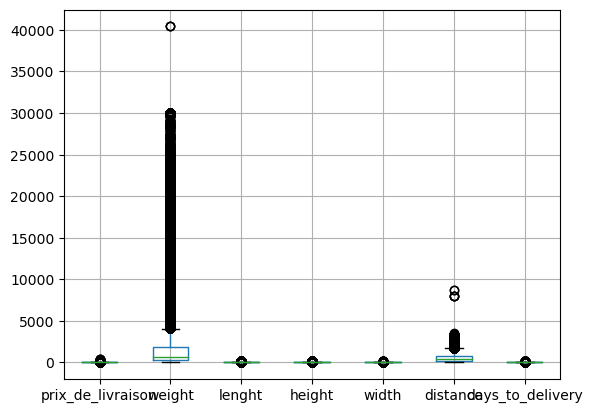

In [14]:
# Visulisation graphique des la dispersion des données pour chaque colonne.
df_features.boxplot()

In [15]:
# Visulisation graphique des dimentions d'un colis
dimension = df_features[['lenght', 'height', 'width']]
dimension.boxplot()

<AxesSubplot:>

In [16]:
# Visulisation des colonnes nan
df_features.isna().sum()

prix_de_livraison       0
weight                 18
lenght                 18
height                 18
width                  18
distance              554
days_to_delivery     2454
dtype: int64

In [17]:
# Création d'un df sans les valeurs nan pour pouvoir faire les boxplots
filtered_data = df_features.dropna()
filtered_data

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
0,7.39,225.0,16.0,10.0,14.0,141.206907,3.0
1,17.99,1000.0,30.0,18.0,20.0,361.255505,15.0
2,7.82,154.0,18.0,9.0,15.0,22.395881,2.0
3,9.54,371.0,26.0,4.0,26.0,74.618935,3.0
4,8.29,625.0,20.0,17.0,13.0,9.184295,2.0
...,...,...,...,...,...,...,...
112645,16.11,700.0,31.0,13.0,20.0,267.777831,12.0
112646,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0
112647,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0
112648,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0


In [18]:
# Visulalisation de la dispersion des données avec les boxplots.
plt.boxplot(filtered_data['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8a0ab910d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8a0ab91670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8a09f85970>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8a0ab91c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8a0ab91ac0>],
 'means': []}

In [19]:
plt.boxplot(filtered_data['distance'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8a0b1064f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8a0b106a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8a0b106250>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8a0b0cd070>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8a0b0cd340>],
 'means': []}

In [20]:
plt.boxplot(filtered_data['days_to_delivery'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8a0b0cdc10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8a0a1bd1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8a0b0cd6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8a0a1bd790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8a0a1bda60>],
 'means': []}

In [21]:
plt.boxplot(filtered_data['prix_de_livraison'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8a0a187310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8a0a1878b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8a0a187070>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8a0a187e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8a0a0fd160>],
 'means': []}

In [22]:
# Visualisation des données les plus hautes avec la fonction .nlargest
df_features.nlargest(20, 'prix_de_livraison')

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
14280,409.68,14675.0,55.0,64.0,52.0,1858.742341,11.0
70088,375.28,30000.0,75.0,58.0,65.0,457.223102,8.0
70089,375.28,30000.0,75.0,58.0,65.0,447.961404,10.0
42993,339.59,25250.0,68.0,66.0,66.0,617.901034,8.0
93987,338.30,30000.0,55.0,75.0,61.0,1702.657180,31.0
93989,322.10,30000.0,55.0,75.0,61.0,432.857213,18.0
92707,321.88,30000.0,55.0,75.0,61.0,632.645902,27.0
4789,321.46,30000.0,100.0,50.0,50.0,241.316425,7.0
25557,317.47,11300.0,44.0,34.0,25.0,2812.759428,18.0
4790,314.40,30000.0,100.0,50.0,50.0,1685.047611,27.0


In [23]:
df_features.nlargest(20, 'weight')

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
85013,16.32,40425.0,13.0,65.0,28.0,776.341568,33.0
85014,12.06,40425.0,13.0,65.0,28.0,339.861658,14.0
85015,16.32,40425.0,13.0,65.0,28.0,221.771105,25.0
1113,45.47,30000.0,50.0,50.0,30.0,483.490656,21.0
1114,27.52,30000.0,50.0,50.0,30.0,20.952085,15.0
1591,116.70,30000.0,76.0,51.0,51.0,299.966546,16.0
1592,150.80,30000.0,76.0,51.0,51.0,2455.435196,13.0
3101,60.73,30000.0,65.0,65.0,65.0,140.656257,8.0
3775,113.38,30000.0,61.0,70.0,65.0,317.052131,14.0
4789,321.46,30000.0,100.0,50.0,50.0,241.316425,7.0


In [24]:
df_features.nlargest(20, 'distance')

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery
28648,76.67,11710.0,45.0,37.0,29.0,8711.002674,22.0
90158,25.60,4900.0,69.0,19.0,41.0,8651.878379,27.0
76664,29.24,1900.0,27.0,9.0,18.0,8002.649447,25.0
81920,29.25,1350.0,27.0,9.0,18.0,8002.649447,29.0
12156,15.11,800.0,20.0,20.0,20.0,7938.634833,24.0
111207,15.11,800.0,21.0,12.0,15.0,7924.621742,52.0
74216,84.94,583.0,30.0,15.0,16.0,3562.715433,NaN
18973,37.31,730.0,25.0,12.0,18.0,3383.776936,32.0
44656,33.79,630.0,19.0,21.0,19.0,3371.253441,25.0
44868,33.24,850.0,20.0,20.0,20.0,3367.693458,30.0


In [25]:
# Création d'un colonne volume en cm3, nous testeront l'utilisté de cette nouvelle colonne plus tard dans une partie corrélation.
filtered_data = filtered_data.assign(volume_cm3 = filtered_data['width'] * filtered_data['height'] * filtered_data['lenght'] )

In [26]:
filtered_data

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,volume_cm3
0,7.39,225.0,16.0,10.0,14.0,141.206907,3.0,2240.0
1,17.99,1000.0,30.0,18.0,20.0,361.255505,15.0,10800.0
2,7.82,154.0,18.0,9.0,15.0,22.395881,2.0,2430.0
3,9.54,371.0,26.0,4.0,26.0,74.618935,3.0,2704.0
4,8.29,625.0,20.0,17.0,13.0,9.184295,2.0,4420.0
...,...,...,...,...,...,...,...,...
112645,16.11,700.0,31.0,13.0,20.0,267.777831,12.0,8060.0
112646,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,8060.0
112647,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,8060.0
112648,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,8060.0


In [27]:
filtered_data.nlargest(20, 'volume_cm3')

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,volume_cm3
42993,339.59,25250.0,68.0,66.0,66.0,617.901034,8.0,296208.0
40919,119.29,30000.0,70.0,60.0,70.0,454.839008,7.0,294000.0
59024,120.19,30000.0,70.0,60.0,70.0,168.874384,30.0,294000.0
86144,119.29,30000.0,70.0,60.0,70.0,200.908263,17.0,294000.0
111426,174.49,30000.0,63.0,63.0,74.0,203.135161,15.0,293706.0
13070,104.12,30000.0,80.0,60.0,60.0,503.308355,9.0,288000.0
24832,104.00,30000.0,80.0,60.0,60.0,500.723463,11.0,288000.0
24833,104.00,30000.0,80.0,60.0,60.0,500.723463,11.0,288000.0
24834,104.00,30000.0,80.0,60.0,60.0,501.421048,12.0,288000.0
57291,137.13,30000.0,80.0,60.0,60.0,694.972098,9.0,288000.0


En conclusion les valeurs ont tout de même l'air d'être assez dispersées avec des valeurs très hautes. Il y a aussi encore des champs vides. Nous allons traiter ces données plus loins dans le projet.